In [2]:
# Cell 1: imports and load features from CSV

from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

import matplotlib.pyplot as plt

# Path for the features file we created before
FEATURES_PATH = Path("models") / "scene_features_val_from_yolo.csv"

df = pd.read_csv(FEATURES_PATH)
print("Loaded feature table shape:", df.shape)
print(df.head())

print("\nScene label distribution:")
print(df["scene_label"].value_counts(dropna=False))

Loaded feature table shape: (2098, 26)
   image_id                                          file_name  total_objs  \
0         1  columbus_ed065d9b86d545b2af0042a058e7e907_0000...           9   
1         2  columbus_ed065d9b86d545b2af0042a058e7e907_0000...          21   
2         3  columbus_ed065d9b86d545b2af0042a058e7e907_0000...           3   
3         4  columbus_ed065d9b86d545b2af0042a058e7e907_0000...           7   
4         5  columbus_ed065d9b86d545b2af0042a058e7e907_0000...           5   

   count_channelization  frac_channelization  count_workers  frac_workers  \
0                     3             0.333333              0      0.000000   
1                     6             0.285714             14      0.666667   
2                     1             0.333333              0      0.000000   
3                     2             0.285714              0      0.000000   
4                     1             0.200000              0      0.000000   

   count_vehicles  frac_vehic

In [3]:
# Cell 2: basic cleaning and build X, y arrays

# Drop rows with no scene label (scene_label is None or NaN)
df_clean = df.dropna(subset=["scene_label"]).reset_index(drop=True)

print("After dropping None scene labels:")
print(df_clean["scene_label"].value_counts())

# For now we keep only the two main classes we have
df_scene = df_clean[df_clean["scene_label"].isin(["workzone_ahead", "lane_shift"])].copy()
print("\nFiltered to workzone_ahead and lane_shift:")
print(df_scene["scene_label"].value_counts())

# Feature columns (all numeric except ID, file_name, scene_label)
cols_drop = ["image_id", "file_name", "scene_label"]
feature_cols = [c for c in df_scene.columns if c not in cols_drop]

X = df_scene[feature_cols].values.astype("float32")

label_to_int = {"workzone_ahead": 0, "lane_shift": 1}
y = df_scene["scene_label"].map(label_to_int).values.astype("int64")

print("\nFeature matrix shape:", X.shape)
print("Label vector shape:", y.shape)

After dropping None scene labels:
scene_label
workzone_ahead    2041
lane_shift          56
Name: count, dtype: int64

Filtered to workzone_ahead and lane_shift:
scene_label
workzone_ahead    2041
lane_shift          56
Name: count, dtype: int64

Feature matrix shape: (2097, 23)
Label vector shape: (2097,)


In [4]:
# Cell 3: stratified train/val split

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=0,
    stratify=y,
)

print("Train shape:", X_train.shape, "Val shape:", X_val.shape)

from collections import Counter
print("Train class counts:", Counter(y_train))
print("Val class counts:", Counter(y_val))

Train shape: (1572, 23) Val shape: (525, 23)
Train class counts: Counter({np.int64(0): 1530, np.int64(1): 42})
Val class counts: Counter({np.int64(0): 511, np.int64(1): 14})


In [5]:
# Cell 4: compute class weights for training

classes = np.unique(y_train)
class_weight_values = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train,
)

class_weight = {c: w for c, w in zip(classes, class_weight_values)}
print("Class weights:", class_weight)

# Convert to per-sample weights
sample_weights_train = np.array([class_weight[yi] for yi in y_train], dtype="float32")


Class weights: {np.int64(0): np.float64(0.5137254901960784), np.int64(1): np.float64(18.714285714285715)}


In [6]:
# Cell 5: train GradientBoosting classifier with sample weights

clf = GradientBoostingClassifier(random_state=0)

clf.fit(X_train, y_train, sample_weight=sample_weights_train)

y_pred_val = clf.predict(X_val)

print(
    classification_report(
        y_val,
        y_pred_val,
        target_names=["workzone_ahead", "lane_shift"],
        digits=3,
    )
)


                precision    recall  f1-score   support

workzone_ahead      0.979     0.914     0.945       511
    lane_shift      0.083     0.286     0.129        14

      accuracy                          0.897       525
     macro avg      0.531     0.600     0.537       525
  weighted avg      0.955     0.897     0.924       525



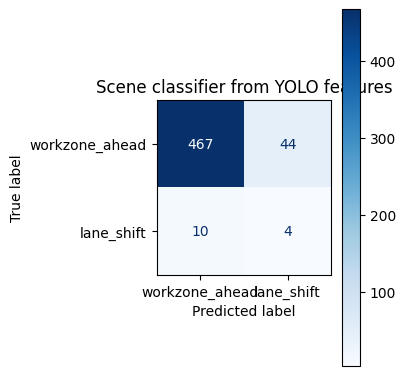

In [7]:
# Cell 6: confusion matrix

cm = confusion_matrix(y_val, y_pred_val)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["workzone_ahead", "lane_shift"],
)

fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(ax=ax, cmap="Blues", values_format="d")
plt.title("Scene classifier from YOLO features")
plt.tight_layout()
plt.show()


In [8]:
# Cell 7: feature importances

importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Top 15 features by importance:")
for rank, idx in enumerate(indices[:15], start=1):
    print(f"{rank:2d}. {feature_cols[idx]:25s}  importance={importances[idx]:.4f}")


Top 15 features by importance:
 1. frac_channelization        importance=0.1373
 2. total_objs                 importance=0.1248
 3. count_channelization       importance=0.1025
 4. frac_vehicles              importance=0.1024
 5. channelization_left        importance=0.0988
 6. count_workers              importance=0.0742
 7. workers_right              importance=0.0565
 8. channelization_right       importance=0.0558
 9. workers_far                importance=0.0488
10. frac_workers               importance=0.0458
11. channelization_near        importance=0.0375
12. channelization_far         importance=0.0373
13. count_vehicles             importance=0.0350
14. workers_left               importance=0.0347
15. channelization_mid         importance=0.0083
